In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

from custom_models.augmentation import basic_plus_color_augmentation, basic_augmentation
from custom_models.bilinear_cnns import fe_resnet
from custom_models.cnns import simple_cnn_bn, base_resnet50
from custom_models.optimization_utilities import get_standard_callbacks
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
from optimization.custom_losses import weighted_categorical_crossentropy


2025-02-18 17:07:18.705041: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-18 17:07:18.705094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-18 17:07:18.705125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 17:07:18.711581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from graphviz import Digraph

# Create a directed graph
flowchart = Digraph(name='EGD_NBI_Analysis', format='png')
flowchart.attr(rankdir='TB', bgcolor='white', fontname='Helvetica', fontsize='12')

# Define nodes (process steps)
nodes = [
    ('Start', 'Start'),
    ('Data Collection', 'Data Collection\n- 80 patients\n- 65 with data'),
    ('Cross-Validation', 'Custom Stratified Cross-Validation\n(Leverage retrospective data)'),
    ('Annotation', 'Annotation Agreement\n(Patch vs. Frame Score)'),
    ('ResNet50', 'ResNet-50 Training\n(Leave-One-Patient-Out CV)\nSmall Variance vs. Prior Work'),
    ('Prediction', 'Patch-Based Risk Stratification\n57/65 Correct\nPerfect Sensitivity'),
    ('End', 'End')
]

# Add nodes to the graph
for node_id, label in nodes:
    flowchart.node(node_id, label=label, shape='rectangle',
                   style='rounded,filled', fillcolor='#e0f0ff',
                   fontname='Helvetica', fontsize='10', margin='0.2')

# Define edges (flow)
edges = [
    ('Start', 'Data Collection'),
    ('Data Collection', 'Cross-Validation'),
    ('Cross-Validation', 'Annotation'),
    ('Annotation', 'ResNet50'),
    ('ResNet50', 'Prediction'),
    ('Prediction', 'End')
]

# Add edges to the graph
for src, dst in edges:
    flowchart.edge(src, dst)

# Save and render the flowchart
flowchart.render(filename='flowchart', cleanup=True, view=True)
print("Flowchart generated as 'flowchart.png'")

Flowchart generated as 'flowchart.png'


In [3]:
target_dir = '../../test_files/EGGIMazing/Dataset3'
model_weights_directory = '../../logs/'
batch_size = 32
num_epochs = 100
learning_rate = 1e-4

def get_model_dirs(model_weights_directory, name):
    model_fold_dir = sorted(os.listdir(model_weights_directory))
    model_dirs = [os.path.join(os.path.join(model_weights_directory, x), 'weights.h5')
                  for x in model_fold_dir if x.startswith(name)]
    return model_dirs

In [4]:
baseline_dirs = get_model_dirs(model_weights_directory, 'embc65_new_patient_resnet_multi_')
#fe_resnet_dirs = get_model_dirs(model_weights_directory, 'embc65_rerun_new_patient_feresnet_multi_')

In [4]:
len(baseline_dirs)#, len(fe_resnet_dirs)

65

In [5]:
dp = DatasetProcessor(target_dir)
df = dp.process()
patient_ids = np.load('../../configs/new_patient_ids.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)
patient_ids_total = sorted(list(set(df_togas.patient_id)))

In [6]:
len(df_togas)

866

In [9]:
x = np.array([0, 1, 1, 2, 0, 2])

In [11]:
np.where(x > 0, 1, 0).shape, x.shape

((6,), (6,))

In [6]:
from sklearn.metrics import confusion_matrix

from evaluation.metrics import categorical_accuracy

from evaluation.metrics import specificity_per_class

from evaluation.metrics import sensitivity_per_class


metrics_baseline = []
metrics_feresnet = []
y_true_ordinals = []
y_baseline_ordinals = []
y_feresnet_ordinals = []

split = dp.patient_wise_split(df_togas,
                                      df_ipo,
                                      patient_ids,
                                      internal_train_size=0.9,
                                      target_variable='eggim_square',
                                      random_state=42)

def compute_metrics(y_true, y_pred, y_true_ordinals, y_pred_ordinals, metrics): # split y_true before and call this for each model
    y_true_ordinal = np.argmax(y_true, axis=-1) # [0 0 1] -> 2
    y_pred_ordinal = np.argmax(y_pred, axis=-1)

    # y_true_ordinal = np.where(y_true_ordinal > 0, 1, 0)
    # y_pred_ordinal = np.where(y_pred_ordinal > 0, 1, 0)
    y_true_ordinals.append(y_true_ordinal)
    y_pred_ordinals.append(y_pred_ordinal)
    y_pred_one_hot = np.zeros_like(y_pred)
    y_pred_one_hot[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1 # [0.2, 0.2, 0.6] -> [0, 0, 1]
    conf_matrix = confusion_matrix(y_true_ordinal, y_pred_ordinal,
                                   labels=[0, 1, 2])
    metrics.append([accuracy_per_class_(conf_matrix),
                    specificity_per_class_(conf_matrix), sensitivity_per_class_(conf_matrix),
                    conf_matrix])
    return metrics

def specificity_per_class_(conf_matrix):
    specificity_per_class = []
    # Number of classes
    num_classes = conf_matrix.shape[0]

    for i in range(num_classes):
        # True Positives for class i
        TP = conf_matrix[i, i]

        # False Positives for class i
        FP = np.sum(conf_matrix[:, i]) - TP

        # False Negatives for class i
        FN = np.sum(conf_matrix[i, :]) - TP

        # True Negatives for class i
        TN = np.sum(conf_matrix) - (TP + FP + FN)

        # Specificity for class i
        if TN + FN != 0:
            specificity = TN / (TN + FP)
        else:
            specificity = np.nan

        specificity_per_class.append(specificity)

    specificity_per_class = np.array(specificity_per_class)
    return specificity_per_class

def accuracy_per_class_(conf_matrix):
    accuracy_per_class = []
    # Number of classes
    num_classes = conf_matrix.shape[0]

    for i in range(num_classes):
        # True Positives for class i
        TP = conf_matrix[i, i]

        # False Positives for class i
        FP = np.sum(conf_matrix[:, i]) - TP

        # False Negatives for class i
        FN = np.sum(conf_matrix[i, :]) - TP

        # True Negatives for class i
        TN = np.sum(conf_matrix) - (TP + FP + FN)

        # Specificity for class i
        if TP + TN + FP + FN != 0:
            accuracy = (TP + TN) / (TP + TN + FP + FN)
        else:
            accuracy = np.nan

        accuracy_per_class.append(accuracy)

    accuracy_per_class = np.array(accuracy_per_class)
    return accuracy_per_class


def sensitivity_per_class_(conf_matrix):
    # Initialize an array to store sensitivity for each class
    sensitivity_per_class = []

    # Number of classes
    num_classes = conf_matrix.shape[0]

    for i in range(num_classes):
        # True Positives for class i
        TP = conf_matrix[i, i]

        # False Negatives for class i
        FN = np.sum(conf_matrix[i, :]) - TP

        # Sensitivity for class i
        if TP + FN != 0:
            sensitivity = TP / (TP + FN)
        else:
            sensitivity = np.nan
        sensitivity_per_class.append(sensitivity)
    return np.array(sensitivity_per_class)



for fold, (df_train, df_val, df_test) in enumerate(split):
    tf_test_df = get_tf_eggim_patch_dataset(df_test,
                                            num_classes=3,
                                            preprocess_fn=tf.keras.applications.resnet.preprocess_input)

    tf_test_df = tf_test_df.batch(batch_size)

    n_classes = 3  # Replace with the number of classes you have

    #
    baseline = base_resnet50(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    baseline.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])

    baseline.load_weights(baseline_dirs[fold])
    # model = fe_resnet(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    #              metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
    #                       Recall(name='recall'),
    #                       AUC(name='auc')])


    #model.load_weights(fe_resnet_dirs[fold])

    y_true = np.concatenate([y for (_, y) in tf_test_df])
    y_pred_baseline = baseline.predict(tf_test_df)
    # y_pred_feresnet = model.predict(tf_test_df)
    compute_metrics(y_true, y_pred_baseline, y_true_ordinals, y_baseline_ordinals, metrics_baseline)
    # compute_metrics(y_true, y_pred_feresnet, y_true_ordinals, y_feresnet_ordinals, metrics_feresnet)

2025-02-18 17:07:27.881390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-18 17:07:27.881660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-18 17:07:27.919844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

1/1 [==============================] - 1s 573ms/step


/tmp/ipykernel_2666431/2294796509.py:60: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 590ms/step


/tmp/ipykernel_2666431/2294796509.py:60: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 603ms/step


/tmp/ipykernel_2666431/2294796509.py:60: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 518ms/step


/tmp/ipykernel_2666431/2294796509.py:60: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 544ms/step


In [7]:
def parse_metrics(metrics):
    cat_acc = np.array([x[0] for x in metrics])
    spec = np.array([x[1] for x in metrics])
    sens = np.array([x[2] for x in metrics])
    confs = np.array([x[3] for x in metrics], dtype=object)
    return cat_acc, spec, sens, confs

In [8]:
from scipy.stats import ttest_rel
baseline_acc, baseline_spec, baseline_sens, baseline_confs = parse_metrics(metrics_baseline)
#feresnet_acc, feresnet_spec, feresnet_sens = parse_metrics(metrics_feresnet)

baseline_metrics_list = [baseline_acc, baseline_spec, baseline_sens]
#feresnet_metrics_list = [feresnet_acc, feresnet_spec, feresnet_sens]

In [12]:
df_togas[]

,bbox,eggim_global,eggim_square,landmark,image_directory,patient_id
0,"[218, 113, 442, 338]",0,0,ii. distal body in anteversion,../../test_files/EGGIMazing/Dataset3/202401171...,PT002
1,"[213, 228, 438, 452]",0,0,ix. distal lesser curvature in retroflexion,../../test_files/EGGIMazing/Dataset3/202401171...,PT002
2,"[190, 231, 415, 455]",0,0,ix. distal lesser curvature in retroflexion,../../test_files/EGGIMazing/Dataset3/202401171...,PT002
3,"[208, 235, 432, 460]",1,0,x. upper body in retroflexion,../../test_files/EGGIMazing/Dataset3/202401171...,PT002
4,"[314, 153, 539, 378]",0,0,vii. proximal antrum - greater curvature/poste...,../../test_files/EGGIMazing/Dataset3/202401191...,PT003
...,...,...,...,...,...,...
861,"[328, 212, 552, 436]",0,0,ix. distal lesser curvature in retroflexion,../../test_files/EGGIMazing/Dataset3/202410161...,PT086
862,"[323, 178, 547, 403]",0,0,x. upper body in retroflexion,../../test_files/EGGIMazing/Dataset3/202410161...,PT086
863,"[277, 140, 501, 364]",1,1,viii. incisura in retroflexion,../../test_files/EGGIMazing/Dataset3/202410161...,PT086
864,"[262, 161, 486, 386]",2,2,vii. proximal antrum - greater curvature/poste...,../../test_files/EGGIMazing/Dataset3/202410161...,PT086


In [11]:
baseline_acc

array([[0.36363636, 0.63636364, 0.54545455],
       [0.72727273, 0.81818182, 0.54545455],
       [0.5       , 0.8       , 0.5       ],
       [1.        , 0.92857143, 0.92857143],
       [0.84615385, 0.69230769, 0.84615385],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 0.83333333, 0.83333333],
       [0.64285714, 0.78571429, 0.57142857],
       [0.69230769, 1.        , 0.69230769],
       [0.69230769, 0.76923077, 0.61538462],
       [0.91666667, 1.        , 0.91666667],
       [0.91666667, 1.        , 0.91666667],
       [1.        , 1.        , 1.        ],
       [0.41666667, 0.58333333, 0.66666667],
       [0.83333333, 0.83333333, 1.        ],
       [1.        , 1.        , 1.        ],
       [0.91666667, 0.91666667, 0.83333333],
       [0.91666667, 0.91666667, 1.        ],
       [0.

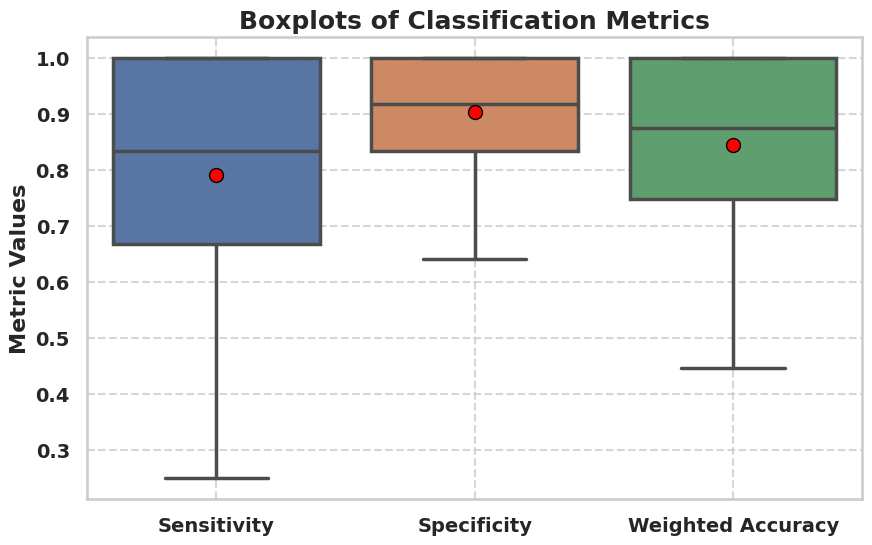

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the numpy arrays are already loaded as baseline_acc, baseline_spec, baseline_sens

# Compute the average value per row for each metric
mean_spec = np.mean(baseline_spec, axis=1)
mean_sens = np.mean(baseline_sens, axis=1)

# Compute weighted accuracy
weighted_acc = (mean_sens + mean_spec) / 2

# Combine into a single dataframe for plotting
df_plot = pd.DataFrame({
    'Sensitivity': mean_sens,
    'Specificity': mean_spec,
    'Weighted Accuracy': weighted_acc
})

# Create boxplots with seaborn
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.set_context("talk")
ax = sns.boxplot(data=df_plot, palette="deep", linewidth=2.5, showmeans=True,
                 meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"black", "markersize":"10"})
plt.ylabel("Metric Values", fontsize=16, fontweight='bold')
plt.xlabel("", fontsize=14)
plt.title("Boxplots of Classification Metrics", fontsize=18, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.grid(True, linestyle="--", linewidth=1.5, alpha=0.8)
plt.show()

In [14]:
baseline_acc

NameError: name 'baseline_acc' is not defined

In [11]:
np.nanmean((baseline_spec + baseline_sens) / 2, axis=0), np.nanstd((baseline_spec + baseline_sens) / 2, axis=0)

(array([0.84959655, 0.83387315, 0.87678275]),
 array([0.1570492 , 0.17940749, 0.1413994 ]))

In [20]:
np.nanmean((baseline_spec + baseline_sens) / 2), np.nanstd((baseline_spec + baseline_sens) / 2)

(0.8503662534912535, 0.16307962620936342)

In [17]:
np.nanmean(baseline_acc, axis=0), np.nanmean(baseline_sens, axis=0), np.nanmean(baseline_spec, axis=0)

(array([0.85302369, 0.90410679, 0.86061161]),
 array([0.78057138, 0.72528139, 0.94423969]),
 array([0.93710317, 0.94991786, 0.84172646]))

In [ ]:
np.nanmean(feresnet_acc, axis=0), np.nanmean(feresnet_sens, axis=0), np.nanmean(feresnet_spec, axis=0)

In [ ]:
np.nanstd(baseline_acc, axis=0), np.nanstd(baseline_sens, axis=0), np.nanstd(baseline_spec, axis=0)

In [ ]:
np.nanstd(feresnet_acc, axis=0), np.nanstd(feresnet_sens, axis=0), np.nanstd(feresnet_spec, axis=0)

In [ ]:
def parse_metric_list(metric_list):
    data = np.array([metric_list[0], np.nanmean(metric_list[1], axis=1), np.nanmean(metric_list[2], axis=1)])
    return data

In [ ]:
np.nanmean(baseline_acc), np.nanstd(baseline_acc)

In [ ]:
data = np.array([cat_acc, np.nanmean(spec, axis=1), np.nanmean(sens, axis=1)])

In [ ]:
data.shape

In [ ]:
np.mean(data, axis=1), np.std(data, axis=1)

In [ ]:
!ls ../../configs/

In [9]:
from evaluation.eggim import *
def replace_landmark_name(landmark):
    new_landmark_name = {'ii': 'distal body',
                    'ix': 'distal lc',
                    'vi': 'proximal ant lc',
                    'vii': 'proximal ant gc/pw',
                    'viii': 'incisura r',
                    'x': 'upper body r',
                    'xii': 'upper body ant'}
    landmark_number = landmark.split('.')[0]
    return new_landmark_name[landmark_number]




dp = DatasetProcessor(target_dir)
df = dp.process()
df['landmark'] = df['landmark'].apply(replace_landmark_name)

print(df)
patient_ids = np.load('../../configs/new_patient_ids.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


                      bbox  eggim_global  eggim_square            landmark  \
0     [221, 135, 445, 359]             1             1           distal lc   
1     [147, 176, 371, 400]             0             0          incisura r   
2     [226, 216, 449, 440]             2             2          incisura r   
3     [198, 130, 422, 355]             2             2          incisura r   
4     [208, 142, 432, 365]             2             2  proximal ant gc/pw   
...                    ...           ...           ...                 ...   
1275  [328, 212, 552, 436]             0             0           distal lc   
1276  [323, 178, 547, 403]             0             0        upper body r   
1277  [277, 140, 501, 364]             1             1          incisura r   
1278  [262, 161, 486, 386]             2             2  proximal ant gc/pw   
1279  [232, 106, 456, 330]             1             1     proximal ant lc   

                                        image_directory  patien

In [ ]:
df_tog

In [ ]:
df = df_togas[['landmark', 'eggim_square']].value_counts()
df

In [20]:
def compute_eggim_patient(patient_df, target_variable):
    df = patient_df[['landmark', target_variable]].value_counts()

    # Assume first landmark/score pair is correct
    eggim_antrum_incisura = (
        df['proximal ant lc'].index[0] +
        df['proximal ant gc/pw'].index[0] +
        df['incisura r'].index[0]
    )

    # Compute eggim_body_1
    body_1_values = []
    if 'distal body' in df:
        body_1_values.append(df['distal body'].index[0])
    if 'upper body ant' in df:
        body_1_values.append(df['upper body ant'].index[0])

    if body_1_values:
        eggim_body_1 = sum(body_1_values) / len(body_1_values)

    # Compute eggim_body_2
    body_2_values = []
    if 'distal lc' in df:
        body_2_values.append(df['distal lc'].index[0])
    if 'upper body r' in df:
        body_2_values.append(df['upper body r'].index[0])

    if body_2_values:
        eggim_body_2 = sum(body_2_values) / len(body_2_values)

    return eggim_antrum_incisura + eggim_body_1 + eggim_body_2

In [11]:
landmark_metrics = {'proximal ant lc': [],
                    'proximal ant gc/pw': [],
                    'incisura r': [],
                    'distal body': [],
                    'upper body ant': [],
                    'distal lc': [],
                    'upper body r': []
                    }

In [18]:
y_true_ordinals

[array([0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2]),
 array([0, 1, 1, 2, 0, 2, 2, 1, 1, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 array([2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 2, 2]),
 array([1, 2, 2, 2, 0, 0, 0, 1, 0, 1, 1, 2, 2]),
 array([1, 0, 0, 0, 0, 0, 2, 2, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([2, 2, 2, 1, 2, 1, 2, 2, 2, 0]),
 array([2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 2]),
 array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]),
 array([0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2]),
 array([0, 1, 0, 1, 1, 0, 2, 1, 1, 2, 1, 0, 0]),
 array([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1]),
 array([0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2]),
 array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2]),
 array([0, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1]),
 array([2, 2, 2, 2, 2, 2, 1,

In [15]:
landmarks_per_patient = []
for i, patient_id in enumerate(patient_ids):
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    landmarks_per_patient += list(df_patient.landmark.values)

In [55]:
landmarks_per_patient

['distal body',
 'proximal ant lc',
 'incisura r',
 'distal lc',
 'upper body r',
 'upper body ant',
 'distal body',
 'distal lc',
 'incisura r',
 'proximal ant gc/pw',
 'proximal ant lc',
 'proximal ant gc/pw',
 'proximal ant lc',
 'incisura r',
 'upper body r',
 'upper body ant',
 'proximal ant gc/pw',
 'proximal ant lc',
 'incisura r',
 'incisura r',
 'distal body',
 'distal lc',
 'incisura r',
 'distal body',
 'upper body r',
 'distal lc',
 'upper body ant',
 'distal body',
 'distal lc',
 'incisura r',
 'proximal ant gc/pw',
 'proximal ant lc',
 'distal body',
 'proximal ant gc/pw',
 'proximal ant lc',
 'incisura r',
 'upper body r',
 'upper body ant',
 'incisura r',
 'distal body',
 'distal lc',
 'proximal ant gc/pw',
 'proximal ant gc/pw',
 'proximal ant gc/pw',
 'proximal ant lc',
 'proximal ant lc',
 'proximal ant lc',
 'proximal ant gc/pw',
 'incisura r',
 'incisura r',
 'upper body r',
 'distal lc',
 'distal body',
 'proximal ant lc',
 'distal body',
 'distal lc',
 'incisura 

In [63]:
np.array(landmarks_per_patient).shape, np.concatenate(y_true_ordinals).shape,


array([0, 2, 2, 2, 2, 0, 1, 1, 2, 1, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 2,
       1, 2, 2, 1, 0, 2, 0, 0, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 0, 1, 1, 2, 2, 1, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2,
       0, 0, 2, 0, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 2, 1, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2,
       0, 0, 1, 1, 1, 2, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2,
       2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 0, 2,
       1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 2, 0, 0, 0,

In [16]:
def get_sensitivity_specificity_accuracy_per_class(conf_mat):
    """
    Given a K x K confusion matrix (for K classes),
    return three arrays of length K:
       sens[k], spec[k], acc[k]  for class k
    computed in a one-vs-rest fashion for each class k.
    """

    K = conf_mat.shape[0]
    # Total samples
    total = np.sum(conf_mat)

    sens = np.zeros(K)
    spec = np.zeros(K)
    acc  = np.zeros(K)

    for k in range(K):
        TP = conf_mat[k, k]
        FN = np.sum(conf_mat[k, :]) - TP
        FP = np.sum(conf_mat[:, k]) - TP
        TN = total - (TP + FN + FP)

        # Sensitivity (a.k.a. recall, TPR)
        sens[k] = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        # Specificity (TNR)
        spec[k] = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        # One-vs-rest Accuracy for class k
        acc[k]  = (TP + TN) / total if total > 0 else 0.0

    return sens, spec, acc

def mean_std_string(values, decimal_places=2):
    """
    Return a string "mean ± std" with given decimal places.
    Example: mean_std_string([0.92, 0.88, 0.95]) -> '0.92 ± 0.03'
    """
    m = np.mean(values)
    s = np.std(values, ddof=1)  # sample std
    return f"{m:.{decimal_places}f} ± {s:.{decimal_places}f}"

metrics_df = pd.DataFrame({'y_true': np.concatenate(y_true_ordinals),
              'y_pred': np.concatenate(y_baseline_ordinals),
              'landmark': np.array(landmarks_per_patient)})

grouped = metrics_df.groupby("landmark")
sens_values_per_landmark = []
spec_values_per_landmark = []
acc_values_per_landmark = []
for lm_name, group in grouped:
    # Confusion matrix for just this landmark
    print(lm_name)
    cm_lm = confusion_matrix(group['y_true'], group['y_pred'], labels=[0, 1,2])
    sens_lm, spec_lm, acc_lm = get_sensitivity_specificity_accuracy_per_class(cm_lm)
    print("Sensitivity", sens_lm, "\nSpecificity", spec_lm, "\nAccuracy", acc_lm)
    # Average the three classes to get a single "landmark-level" sensitivity, etc.
    sens_values_per_landmark.append(sens_lm)
    spec_values_per_landmark.append(spec_lm)
    acc_values_per_landmark.append(acc_lm)
    print()

distal body
Sensitivity [0.82089552 0.8        1.        ] 
Specificity [0.85714286 0.97101449 0.86111111] 
Accuracy [0.82432432 0.95945946 0.86486486]

distal lc
Sensitivity [0.81609195 0.87878788 0.95      ] 
Specificity [0.96226415 0.92523364 0.90833333] 
Accuracy [0.87142857 0.91428571 0.91428571]

incisura r
Sensitivity [0.70212766 0.62       1.        ] 
Specificity [0.9382716  0.96153846 0.74226804] 
Accuracy [0.8515625 0.828125  0.8046875]

proximal ant gc/pw
Sensitivity [0.76829268 0.86363636 0.91666667] 
Specificity [0.98275862 0.90677966 0.875     ] 
Accuracy [0.85714286 0.9        0.88571429]

proximal ant lc
Sensitivity [0.75       0.68421053 0.94444444] 
Specificity [0.91891892 0.98913043 0.77659574] 
Accuracy [0.84615385 0.9        0.82307692]

upper body ant
Sensitivity [0.87692308 0.66666667 1.        ] 
Specificity [0.85714286 0.98507463 0.88311688] 
Accuracy [0.87341772 0.93670886 0.88607595]

upper body r
Sensitivity [0.75 1.   1.  ] 
Specificity [1.         0.96153

In [17]:
metrics = []
for lm_name, group in grouped:
    # Confusion matrix for just this landmark
    print(lm_name)
    conf_matrix = confusion_matrix(group['y_true'], group['y_pred'], labels=[0, 1,2])

    metrics.append([accuracy_per_class_(conf_matrix),
                    specificity_per_class_(conf_matrix), sensitivity_per_class_(conf_matrix),
                    conf_matrix])
    # Average the three classes to get a single "landmark-level" sensitivity, etc.
    print(accuracy_per_class_(conf_matrix),
                    specificity_per_class_(conf_matrix), sensitivity_per_class_(conf_matrix))
    print("\n")



distal body
[0.82432432 0.95945946 0.86486486] [0.85714286 0.97101449 0.86111111] [0.82089552 0.8        1.        ]


distal lc
[0.87142857 0.91428571 0.91428571] [0.96226415 0.92523364 0.90833333] [0.81609195 0.87878788 0.95      ]


incisura r
[0.8515625 0.828125  0.8046875] [0.9382716  0.96153846 0.74226804] [0.70212766 0.62       1.        ]


proximal ant gc/pw
[0.85714286 0.9        0.88571429] [0.98275862 0.90677966 0.875     ] [0.76829268 0.86363636 0.91666667]


proximal ant lc
[0.84615385 0.9        0.82307692] [0.91891892 0.98913043 0.77659574] [0.75       0.68421053 0.94444444]


upper body ant
[0.87341772 0.93670886 0.88607595] [0.85714286 0.98507463 0.88311688] [0.87692308 0.66666667 1.        ]


upper body r
[0.81967213 0.96721311 0.85245902] [1.         0.96153846 0.83018868] [0.75 1.   1.  ]




In [126]:
for i, (lm_name, group) in enumerate(grouped):
    print(lm_name)
    for j, l in zip(range(3), ['acc', 'spec', 'sens']):
        print(l, np.mean(metrics[i][j], axis=1), "+-", np.std(metrics[i][j], axis=1))
    print()

distal body


AxisError: axis 1 is out of bounds for array of dimension 1

In [129]:
sens_ = np.array([metric[-2] for metric in metrics])

In [131]:
np.mean(sens_, axis=0), np.std(sens_, axis=0)

(array([0.78347584, 0.78761449, 0.97301587]),
 array([0.05383274, 0.12692421, 0.03258804]))

In [95]:
np.mean(sens_values_per_landmark, axis=0), np.std(sens_values_per_landmark, axis=0)

(array([0.78347584, 0.78761449, 0.97301587]),
 array([0.05383274, 0.12692421, 0.03258804]))

In [94]:
np.mean(spec_values_per_landmark, axis=-1), np.std(spec_values_per_landmark, axis=-1)

(array([0.89642282, 0.93194371, 0.8806927 , 0.92151276, 0.8948817 ,
        0.90844479, 0.93057571]),
 array([0.05276915, 0.02252261, 0.09834083, 0.04520898, 0.08841602,
        0.05521329, 0.07270025]))

In [21]:
np.mean(sens_values_per_landmark, axis=-1), np.std(sens_values_per_landmark, axis=-1)

eggim_scores = {}
patients_dfs = []
for i, patient_id in enumerate(patient_ids):
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_baseline_ordinals[i]
    patients_dfs.append(df_patient)
    try:
        eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
        eggim_global = compute_eggim_patient(df_patient,
                                      target_variable='eggim_global')
        eggim_pred = compute_eggim_patient(df_patient,
                                      target_variable='pred')
        eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                        'eggim_pred': eggim_pred}
    except:
        print("bad ", patient_id)
eggim_df = pd.DataFrame(eggim_scores).T

/tmp/ipykernel_2666431/2471363693.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_baseline_ordinals[i]
/tmp/ipykernel_2666431/2471363693.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_baseline_ordinals[i]
/tmp/ipykernel_2666431/2471363693.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [22]:
np.argmax(y_pred_baseline, axis=2)

,eggim_square,eggim_global,eggim_pred
PT004,1.0,1.0,4.5
PT005,3.0,2.5,8.0
PT006,1.0,1.0,6.0
PT009,8.0,8.5,8.0
PT011,5.0,6.0,6.5
...,...,...,...
PT081,5.0,5.0,8.0
PT082,4.5,4.5,4.5
PT083,0.0,0.0,0.0
PT084,6.0,6.0,5.0


In [ ]:


eggim_scores = {}
patients_dfs = []
for i, patient_id in enumerate(patient_ids):
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_baseline_ordinals[i]
    patients_dfs.append(df_patient)
    try:
        eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
        eggim_global = compute_eggim_patient(df_patient,
                                      target_variable='eggim_global')
        eggim_pred = compute_eggim_patient(df_patient,
                                      target_variable='pred')
        eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                        'eggim_pred': eggim_pred}
    except:
        print("bad ", patient_id)
eggim_df = pd.DataFrame(eggim_scores).T

In [28]:
from sklearn.metrics import confusion_matrix
# Function to calculate sensitivity and specificity
def calculate_eggim_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print("True positives", tp)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn)  if (tp + tn + fp + fn) > 0 else 0.0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    return sensitivity, specificity, accuracy, ppv

cutoffs = [3, 4, 5, 6, 7, 8, 9]

hard_cutoff = 5
y = np.array([1 if eggim >= hard_cutoff else 0 for eggim in eggim_df['eggim_square'].values])
print(sum(y))
print(y)
for cutoff in cutoffs:
    print("cutoff", cutoff)

    y_pred = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values])

    print("number of mistakes", np.sum(y != y_pred))
    metrics_ = calculate_eggim_metrics(y, y_pred)
    print("PPV", metrics_[-1], "Sensitivity", metrics_[0], "Specificity", metrics_[1], 'Accuracy', metrics_[2])
    print()

In [36]:
patients_dfs = pd.concat(patients_dfs)
patients_dfs.to_csv('resnet_scores.csv')
eggim_df.to_csv("resnet_eggim_revised.csv")

In [33]:
import matplotlib.pyplot as plt

# Assuming 'eggim_df' is your dataframe
plt.hist(eggim_df['eggim_square'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of eggim_square')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(range(0, 11))  # Ensure ticks for values from 0 to 10
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


cutoff 5
number of mistakes 8
True Positives: 13
True Negatives: 44
False Positives: 8
False Negatives: 0
PPV 0.6190476190476191 NPV 1.0 6.5 0.0



In [37]:
# Count the total number of patients
total_patients = len(eggim_df)

# Count the number of patients with eggim_square <= 5
patients_below_5 = len(eggim_df[eggim_df['eggim_square'] <= 5])
patients_above_5 = total_patients - patients_below_5

# Calculate the percentage
percentage_below_5 = (patients_below_5 / total_patients) * 100
percentage_above_5 = (patients_above_5 / total_patients) * 100

# Data for bar plot
categories = ['≤ 5', '> 5']
percentages = [percentage_below_5, percentage_above_5]

# Create the bar plot
plt.bar(categories, percentages, color=['green', 'red'], alpha=0.7)
plt.title('EGGIM Tallies')
plt.ylabel('Percentage')
plt.ylim(0, 100)

# Annotate bars with percentages
for i, value in enumerate(percentages):
    plt.text(i, value + 2, f'{value:.1f}%', ha='center', fontsize=12)

plt.show()

True Positives: 13
True Negatives: 44
False Positives: 8
False Negatives: 0
Sensitivity: 1.0000 (95% CI: 1.0000, 1.0000)
Specificity: 0.8462 (95% CI: 0.6225, 1.0698)
Accuracy: 0.8769 (95% CI: 0.6733, 1.0805)
PPV (Precision): 0.6190 (95% CI: 0.3181, 0.9200)
NPV: 1.0000 (95% CI: 1.0000, 1.0000)
PLR (Positive Likelihood Ratio): 6.5000 (95% CI: 0.0303, 1393.2363)
NLR (Negative Likelihood Ratio): 0.0000 (95% CI: 0.0000, 0.0000)


In [38]:
print("FE-RESNET")

eggim_scores = {}
patients_dfs = []
for i, patient_id in enumerate(patient_ids):
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_feresnet_ordinals[i]
    patients_dfs.append(df_patient)
    try:
        eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
        eggim_global = compute_eggim_patient(df_patient,
                                      target_variable='eggim_global')
        eggim_pred = compute_eggim_patient(df_patient,
                                      target_variable='pred')
        eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                        'eggim_pred': eggim_pred}
    except:
        print("bad ", patient_id)
eggim_df = pd.DataFrame(eggim_scores).T

True Positives: 13
True Negatives: 44
False Positives: 8
False Negatives: 0
Sensitivity: 1.0000 (95% CI: 1.0000, 1.0000)
Specificity: 0.8462 (95% CI: 0.6225, 1.0698)
Accuracy: 0.8769 (95% CI: 0.6733, 1.0805)
PPV (Precision): 0.6190 (95% CI: 0.3181, 0.9200)
NPV: 1.0000 (95% CI: 1.0000, 1.0000)
PLR (Positive Likelihood Ratio): 6.5000 (95% CI: 3.4362, 12.2954)
NLR (Negative Likelihood Ratio): 0.0000 (95% CI: 0.0000, 0.0000)


In [ ]:
from sklearn.metrics import confusion_matrix
# Function to calculate sensitivity and specificity
def calculate_eggim_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print("True positives", tp)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn)  if (tp + tn + fp + fn) > 0 else 0.0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    return sensitivity, specificity, accuracy, ppv

cutoffs = [3, 4, 5, 6, 7, 8, 9]

hard_cutoff = 5
y = np.array([1 if eggim >= hard_cutoff else 0 for eggim in eggim_df['eggim_square'].values])
print(sum(y))
print(y)
for cutoff in cutoffs:
    print("cutoff", cutoff)

    y_pred = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values])

    print("number of mistakes", np.sum(y != y_pred))
    metrics_ = calculate_eggim_metrics(y, y_pred)
    print("PPV", metrics_[-1], "Sensitivity", metrics_[0], "Specificity", metrics_[1], 'Accuracy', metrics_[2])
    print()

In [ ]:


def calculate_eggim_metrics(y_true, y_pred):
    # Placeholder for actual metric calculation logic
    sensitivity = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1)
    specificity = np.sum((y_true == 0) & (y_pred == 0)) / np.sum(y_true == 0)
    return sensitivity, specificity

cutoffs = [3, 4, 5, 6]
mistakes = []
sensitivities = []
specificities = []

# Calculate metrics for each cutoff
for cutoff in cutoffs:
    y = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square']])
    y_pred = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred']])

    mistakes.append(np.sum(y != y_pred))

    metrics_ = calculate_eggim_metrics(y, y_pred)
    sensitivities.append(metrics_[0])
    specificities.append(metrics_[1])

# Plotting with discrete x-axis and dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Convert cutoffs to discrete labels
cutoff_labels = [str(c) for c in cutoffs]

# Primary y-axis for sensitivity and specificity
ax1.plot(cutoffs, sensitivities, marker='o', label="Sensitivity", color="blue")
ax1.plot(cutoffs, specificities, marker='o', label="Specificity", color="green")
ax1.set_xlabel("Cutoff")
ax1.set_ylabel("Sensitivity / Specificity", color="black")
ax1.set_xticks(cutoffs)
ax1.set_xticklabels(cutoff_labels)
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc="upper left")
ax1.grid(True, linestyle='--', alpha=0.5)

# Secondary y-axis for number of mistakes
ax2 = ax1.twinx()
ax2.plot(cutoffs, mistakes, marker='o', label="Mistakes", color="red", linestyle='dashed')
ax2.set_ylabel("Number of Mistakes", color="red")
ax2.tick_params(axis='y', labelcolor="red")
ax2.legend(loc="upper right")

# Add a separate x-axis line for better visibility
ax1.axhline(y=0, color='black', linewidth=0.8, linestyle='--', alpha=0.7)

# Title and layout adjustments
plt.title("Performance Metrics and Mistakes Across Cutoffs (Discrete X-Axis)")
fig.tight_layout()
plt.show()


In [ ]:
# Adjust the visual distance between ticks on the secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Convert cutoffs to discrete labels
cutoff_labels = [str(c) for c in cutoffs]

# Primary y-axis for sensitivity and specificity
ax1.plot(cutoffs, sensitivities, marker='o', label="Sensitivity", color="blue")
ax1.plot(cutoffs, specificities, marker='o', label="Specificity", color="green")
ax1.set_xlabel("Cutoff")
ax1.set_ylabel("Sensitivity / Specificity", color="black")
ax1.set_xticks(cutoffs)
ax1.set_xticklabels(cutoff_labels)
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc="upper left")
ax1.grid(True, linestyle='--', alpha=0.5)

# Secondary y-axis for number of mistakes with adjusted scale compression
ax2 = ax1.twinx()
ax2.plot(cutoffs, mistakes, marker='o', label="Mistakes", color="red", linestyle='dashed')
ax2.set_ylabel("Number of Mistakes", color="red")
ax2.tick_params(axis='y', labelcolor="red")
ax2.set_ylim(min(mistakes) , max(mistakes))  # Compressing the vertical range

ax2.legend(loc="upper right")

# Add a separate x-axis line for better visibility
ax1.axhline(y=0, color='black', linewidth=0.8, linestyle='--', alpha=0.7)

# Title and layout adjustments
plt.title("Performance Metrics and Mistakes Across Cutoffs (Compressed Right Axis)", fontsize=16)
fig.tight_layout()
plt.show()


In [ ]:
eggim_scores = {}
patients_dfs = []
for i, patient_id in enumerate(patient_ids):
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_baseline_ordinals[i]
    patients_dfs.append(df_patient)
    eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
    eggim_global = compute_eggim_patient(df_patient,
                                  target_variable='eggim_global')
    eggim_pred = compute_eggim_patient(df_patient,
                                  target_variable='pred')
    eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                    'eggim_pred': eggim_pred}
eggim_df = pd.DataFrame(eggim_scores).T

In [ ]:
patients_dfs = pd.concat(patients_dfs)
patients_dfs.to_csv('baseline_scores.csv')
eggim_df.to_csv("fe_eggim_revised.csv")

In [ ]:

cutoff = 5
y = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values])
y_pred = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values])

print(np.sum(y != y_pred))

calculate_eggim_metrics(np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values]),
                                  np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values]))

In [ ]:
eggim_df

In [ ]:
y = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values])
y_pred = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values])

np.sum(y != y_pred)

In [ ]:
print(os.getcwd())

In [ ]:
# minimum error of patch vs global labels
best_possible_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 0]))

In [ ]:
# error of patch predictions vs patch labels
patch_eggim_mae =  np.mean(np.abs(eggim_df.iloc[:, 0] -  eggim_df.iloc[:, 2]))

In [ ]:
patch_global_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 2]))

In [ ]:
patch_eggim_mae

In [ ]:
# patch ground truth vs patch pred:
patch_eggim_mae

In [ ]:
# global ground truth vs patch pred
patch_global_eggim_mae

In [ ]:
# global ground truth vs patch pred "adjusted" with minimum error in square labels
patch_global_eggim_mae - best_possible_eggim_mae

In [ ]:
eggim_df

In [ ]:
eggim_df.to_excel('eggim65.xlsx', index=True)

In [ ]:
!pip install openpyxl

In [ ]:
!ls

In [ ]:
!pwd